Number of columns before dropped columns: 1569
Number of columns after dropped columns: 206


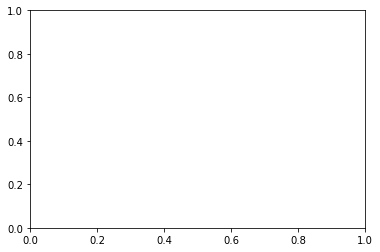

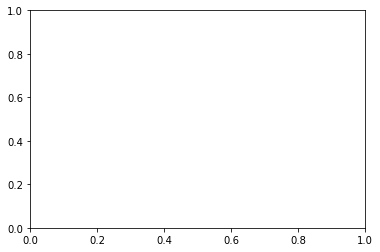

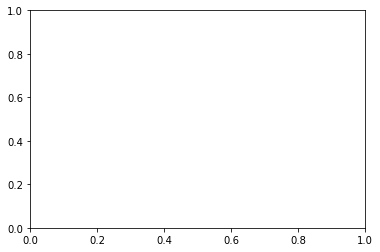

In [36]:
# LOG OF CHANGES
# Nu is het tijd om L1 regularisation proberen toe te passen
# Potentiële voordelen: betere regularisatie --> betere generaliseerbaarheid
# Probeer dit na te doen:
# https://colab.research.google.com/drive/1DkImLNM6wG5ofFvf7vErsRw5A1l3gITh?authuser=1#scrollTo=ALzYAiCVIHHE
# slides: https://brightspace.tudelft.nl/d2l/le/content/280057/viewContent/1900863/View
# site: https://www.geeksforgeeks.org/ml-implementing-l1-and-l2-regularization-using-sklearn/

import os
import sys
clear = lambda: os.system('cls')  # On Windows System
clear()
sys.path.insert(0, r'C:\Users\linda\Dropbox\TM\Stagedocumenten\Q2 2021-2022\IDA-model-main\IDA-model\Functions')
# Import the right data packages
import pandas as pd
import numpy as np
import seaborn as sns
from v1_baseline import baseline
from v1_drop_data import drop_data
from v1_feature_selection import find_sign_features
from v1_impute_data import impute_data
from v1_load_data import load_data
from v1_mean_ROC_curves import mean_ROC_curves
from v1_pipeline_model import pipeline_model
from v1_scale_data import scale_data
from v1_stratify import stratify
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy import stats
from statistics import mean
from statistics import stdev
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel
from time import time


# Load and merge data. Define paths and columns wanted from Excel files
path_data = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v6_dataset.xlsx'
columns_data = "A:BBB"
path_labels = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/IDA_aangevuld.xls'
columns_labels = "A:B"
path_phecodes = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/phecodes_filled_binary.xlsx'
columns_phecodes = "A:R"
path_specialisms = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/Letters_DBC_combined.xlsx'
columns_specialisms = "A:BW"
path_decimals = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/afronden_features.xlsx'
columns_decimals = 'A:HI'
path_baseline = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/baseline.xlsx'
columns_baseline = 'A:C'
path_extra = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v3_extra.xlsx'
columns_extra = 'A:D'
path_brieven = 'C:/Users/linda/Dropbox/TM/Stagedocumenten/Q2 2021-2022/IDA-model-main/model/v2_brieven.xlsx'
columns_brieven = 'A:BR'

# df data contains most of the features needed to build the model
df_data = load_data(path_data, columns_data)
# df labels contains the label ID/ no ID
df_labels = load_data(path_labels, columns_labels)
# df phecodes contains the data about the diagnoses a patient has, categorized into groups
df_phecodes = load_data(path_phecodes, columns_phecodes)
# df spec contains the data about what specialisms a patient visited
df_spec = load_data(path_specialisms, columns_specialisms)
# df decimal contains the amount of decimals for rounding the different features
df_decimal = load_data(path_decimals, columns_decimals)
# df baseline contains baseline characteristics age and gender
df_baseline = load_data(path_baseline, columns_baseline)
# df_extra contains extra characteristics like BMI and opnames
df_extra = load_data(path_extra, columns_extra)
# df_brieven contains the letters sent from specialisms
df_brieven = load_data(path_brieven,columns_brieven)

# Merge dataframes
df_hix_spec = df_data.merge(df_spec, on='Pt_no', how='outer')
df_hix_phecodes = df_hix_spec.merge(df_phecodes, on='Pt_no', how='outer')
# In df hix, all features are merged inside one dataframe. The specialisms, phecodes and labels are added
df_hix = df_hix_phecodes.merge(df_labels, on='Pt_no', how='inner')
# Now add all the extra features
df_ex = df_hix.merge(df_extra, on='Pt_no',how = 'inner')
# Now add the letters from the specialisms
df_all = df_ex.merge(df_brieven, on = 'Pt_no', how = 'inner')
print('Number of columns before dropped columns: ' + str(len(df_all.columns)))

# Defining thresholds for dropping rows and columns with missing data (threshold of amount of non-NA values required)
threshold_column = 0.6
threshold_row = 0.6

# Drop columns and rows with too many NaN's
df_dropped = drop_data(threshold_column, threshold_row, df_all)
# Omdat ik toch wel graag de variabele cortisol erbij wil omdat die me interessant lijkt:
df_dropped['Cortisol'] = df_all['Cortisol']
print('Number of columns after dropped columns: ' + str(len(df_dropped.columns)))

# Balance set by picking random samples from no ID group # hierrr
df_ID_1 = df_dropped.loc[df_dropped['Label'] == 1.0]
df_ID_0_all = df_dropped.loc[df_dropped['Label'] == 0.0]

# To perform stratified random sampling, the gender of the ID group is checked
# Check baseline characteristics of subset
# Merge the dataframes of ID and no ID with the baseline characteristics in df baseline (age and gender)
# Exploratory data analysis
df_0_all_baseline = df_ID_0_all.merge(df_baseline, on='Pt_no', how='inner')
df_1_baseline = df_ID_1.merge(df_baseline, on='Pt_no', how='inner')
#characteristics = baseline(df_0_all_baseline, df_1_baseline)

# Stratify the data
df_control = stratify(df_0_all_baseline, df_1_baseline)

# Nou moeten de dataframes van no ID en ID weer bij elkaar 
df_comb = pd.concat([df_1_baseline,df_control])
df_comb = df_comb.drop(['Leeftijd', 'Geslacht'], axis = 1 )

# Defining empty lists needed later
tprs_RF_all = []
aucs_RF_all = []
auc_RF_all = []
spec_RF_all = []
sens_RF_all = []
accuracy_RF_all = []
tprs_RF_fin = []
aucs_RF_fin = []
auc_RF_fin = []
spec_RF_fin = [] 
sens_RF_fin = []
accuracy_RF_fin = []
tprs_SVM_fin = []
aucs_SVM_fin = [] 
auc_SVM_fin = []
spec_SVM_fin = [] 
sens_SVM_fin = []
accuracy_SVM_fin = []
accuracy_SVM_sign = []
perm_importances_dfs = []
sign_features_dfs = []

# Define the necessary figures
_, axis_RF_all = plt.subplots()
_, axis_RF_fin = plt.subplots()
_, axis_SVM_fin = plt.subplots()

# Define data and labels
labels = df_comb['Label']
data = df_comb.drop(['Pt_no', 'Label'], axis=1)

# Define ordinal, binary and continuous keys
ordinal_keys = ['Anti-epileptics', 'Psychofarmaca', 'Antacids', 'Anti-hypertensives', 'VitB12', 'Iron-tablets', 'Specialisms_hospitalization', 'Radiologic_investigations', 'Total_amount_ICD10s']
binary_keys = list(df_spec.keys()) + list(df_phecodes.keys()) + list(df_brieven.keys())
binary_keys.remove('Pt_no')
binary_keys.remove('Pt_no')
binary_keys.remove('Pt_no')
#continuous_keys = ['Length', 'Opnames_spec', 'Beeldvormende_verr', 'HR', 'RRsyst', 'RRdiast', 'Vrij T4', 'Hemolytische index', 'Icterische index', 'Lipemische index', 'TSH', 'Alk.Fosf.', 'ALAT', 'ASAT', 'Calcium', 'CKD-EPI eGFR', 'Glucose/PL', 'Hemoglobine', 'Kalium', 'Kreatinine', 'LDH', 'MCV', 'Natrium', 'RDW', 'Tot. Bilirubine', 'Gamma-GT', 'Ureum', 'BMI']
continuous_keys = ['Length', 'Opnames_spec', 'Beeldvormende_verr', 'HR', 'RRsyst', 'RRdiast', 'Cortisol', 'FSH', 'Vrij T4', 'Hemolytische index', 'Icterische index', 'Lipemische index', 'TSH', 'Alk.Fosf.', 'ALAT', 'Albumine', 'ASAT', 'Calcium', 'CKD-EPI eGFR', 'Glucose/PL', 'Hemoglobine', 'Kalium', 'Kreatinine', 'LDH', 'Leukocyten', 'MCV', 'Natrium', 'RDW', 'Tot. Bilirubine', 'Trombocyten', 'Gamma-GT', '25-OH Vitamine D', 'Ureum', 'LDL-Cholesterol', 'BMI']

# Test data splitten uit totale dataset
train_data2, test_data2 = train_test_split(df_comb, test_size=0.1, random_state=25)
train_data = train_data2.drop(['Pt_no', 'Label'], axis=1)
test_data = test_data2.drop(['Pt_no', 'Label'], axis=1)
train_label = train_data2['Label']
test_label = test_data2['Label']

# Impute the missing data
# Impute data, but exclude the BMI in this. Add BMI again after imputation.
impute_train, impute_test = impute_data(train_data, test_data, df_decimal) #imputes data for all columns 
# Imputed length and weight, now calculate BMI from that and delete weight again
impute_train['BMI'] = np.round(impute_train['Weight']/((impute_train['Length']/100)**2), decimals=2)
impute_test['BMI'] = np.round(impute_test['Weight']/((impute_test['Length']/100)**2), decimals=2)
impute_train = impute_train.loc[:,impute_train.columns!='Weight']
impute_test = impute_test.loc[:,impute_test.columns!='Weight']

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379560917373933, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379561280846318, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379561684208877, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379562131838924, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37956262859449, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379563179866743, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379563791637864, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379564470546793, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37956522396079, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379566060055453, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37956698789558, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37956801756348, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37956916022401, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379570428295484, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379571835496368, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379573397111773, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379575130082138, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379577053205523, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379579187341555, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379581555636378, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.3795841837741, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37958710025373, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.3795903366976, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37959392819332, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37959791367258, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379602336331587, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379607243288874, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379612689246564, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37961873246994, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37962543840797, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379632879712453, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379641136939394, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37965029940112, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379660466259057, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37967174736873, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379684262856, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37969814920156, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37971355890279, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379730656311143, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379749622862963, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37977066863487, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. Yo

	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.37984865516237, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.3798805362388, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379915891731308, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379955108869833, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.379998605755265, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.380046848372743, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.3801003570903, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38015969270322, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38022546856542, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.380298408648926, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38037929073085, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.380468926270343, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.380568277370543, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.380678373443242, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.3808003562528, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.380935520556555, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.381085208402222, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.381250959884998, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.381434439139035, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.381637551922704, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38186224450555, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38211083814978, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38268893670331, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.383023457823764, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.383392443477014, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.383799447061307, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.384247966704812, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.384742010805624, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.385285754345, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.385883299025938, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38653934790315, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.3872589567162, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.38804657518655, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.388906457003678, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.3898381689555, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.390855043308587, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.39197573653715, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.39319028350557, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.39450583692075, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.395935598836456, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.397517865953937, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.39924532674231, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.40110314985265, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.40318153990423, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.405483663661983, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.40799585452721, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You

	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.4138761301447, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.41718386073179, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.420747353070308, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.424758601183854, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.429225839555194, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.434003231704885, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.43913965720114, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.444589753954872, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.450422236489413, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.45668033178392, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.46325548764173, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.47012345354528, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.47742673277602, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.48533602002332, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.493567623431186, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.512891411399906, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.52395355620346, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.53530188190829, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.546982517025334, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.55897692700231, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.57491053073878, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.592319050683358, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.610870238588205, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.63123894763244, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.653087444482427, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.67718483269791, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.70345140601303, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.7313950888513, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.761658820714523, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.7982102542863, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.839342989141006, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.883724473125945, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.93151630091475, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.983038580009662, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.04255471616577, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.108111000376812, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.1795838955782, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.256878762948936, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.33988645856532, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.42904843545034, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.528143507175113, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.643570702592143, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.769604928464588, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.90741141297515, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.05815209960761, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.214362204518874, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.378672141000855, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.55723838295442, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.750911034247608, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.957276132559546, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.173843761935164, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.451279758395767, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.698366526823314, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.96677912994714, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.254381279112184, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.54637593728095, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.851025590258676, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.167204567594325, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.50326776716399, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.833105153925374, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.151180812302503, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.45592387175405, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.716482146869545, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.910204750141965, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(



	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.240388174585487, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.556674416215618, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.87384220519366, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.20257726081647, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.54050789908844, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.8735914419587, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.20668554593446, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.53968885803946, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.88327229987497, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You 

	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51

C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.626793013493014, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.019780501891645, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.410114787842645, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. Y


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.207534242205476, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.61397600677014, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.014389609941134, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. Yo

	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.82531527878379, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.02317920415032, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.13132120262158, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You 

	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.12607892329517, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.05053153894693, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.998926482193795, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You

	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.324665519374854, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.324959388678707, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.298991895875204, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(


	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.145838319352393, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.44274441111797, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.255296723640754, tolerance: 2.32
  model = cd_fast.enet_coordinate_descent(
C:\Users\linda\miniconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. Yo

	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51
	 Misclassified: 0 / 51


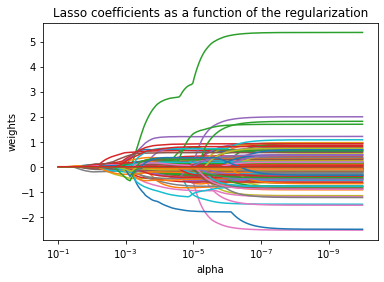

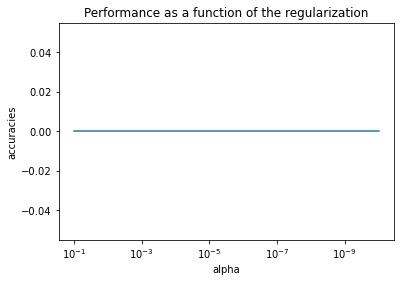

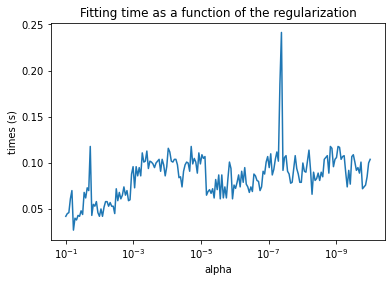

In [38]:
# LASSO gaat feature selection voor ons doen, dus we kunnen eigenlijk direct van de dataframe door naar de LASSO
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
# Construct classifiers
coefs = []
accuracies = []
times = []
for a in alphas:
    # Fit classifier
    clf = Lasso(alpha=a, fit_intercept=False, tol=1e-2, normalize = True)
    t0 = time()
    clf.fit(impute_train, train_label)
    duration = time() - t0
    y_pred = clf.predict(impute_test)
    message = ("\t Misclassified: %d / %d" % ((test_label == y_pred).sum(), test_label.shape[0]))
    print(message)
    
    # Append statistics
    accuracy = float((test_label == y_pred).sum()) / float(test_label.shape[0])
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()

# Note: you may get a FutureWarning, which you can for now just ignore


In [39]:
from sklearn.datasets import fetch_20newsgroups

def load_text_dataset(N_features=100):
    '''
    Load dataset for classifying text documents by topic.
    '''
    categories = [
        'alt.atheism',
        'talk.religion.misc'
    ]

    remove = ('headers', 'footers', 'quotes')

    print("Loading 20 newsgroups dataset for categories:")
    print(categories if categories else "all")

    data_train = fetch_20newsgroups(subset='train', categories=categories,
                                    shuffle=True, random_state=42,
                                    remove=remove)

    data_test = fetch_20newsgroups(subset='test', categories=categories,
                                   shuffle=True, random_state=42,
                                   remove=remove)
    print('data loaded')
    print(data_train)
    print(data_test)

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names


# Load a larger dataset with more features
X_train, X_test, y_train, y_test = load_text_dataset(N_features=1000)
# This dataset contains samples of different text types. We have extracte two classes: atheist texts and religious texts.
# Originally, this dataset contained thousands of features. Using univariate selection, we can quickly select a subset of 1000.

# Display the weights and compute error for multiple values for alpha
n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)

# Construct classifiers
coefs = []
accuracies = []
times = []
for a in alphas:
    # Fit classifier
    clf = RidgeClassifier(alpha=a, fit_intercept=False)
    t0 = time()
    clf.fit(X_train, y_train)
    duration = time() - t0
    y_pred = clf.predict(X_test)
    message = ("\t Misclassified: %d / %d" % ((y_test != y_pred).sum(), y_test.shape[0]))
    print(message)
    
    # Append statistics
    accuracy = float((y_test != y_pred).sum()) / float(y_test.shape[0])
    times.append(duration)
    accuracies.append(accuracy)
    coefs.append(clf.coef_)

# #############################################################################
# Display results

# Weights
plt.figure()
ax = plt.gca()
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Performance
plt.figure()
ax = plt.gca()
ax.plot(alphas, accuracies)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('accuracies')
plt.title('Performance as a function of the regularization')
plt.axis('tight')
plt.show()

# Times
plt.figure()
ax = plt.gca()
ax.plot(alphas, times)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('times (s)')
plt.title('Fitting time as a function of the regularization')
plt.axis('tight')
plt.show()

# Note: you may get a FutureWarning, which you can for now just ignore

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
data loaded
{'data': ['Benedikt Rosenau writes, with great authority:\n\n\n"Contradictory" is a property of language.  If I correct this to\n\n\n      THINGS DEFINED BY CONTRADICTORY LANGUAGE DO NOT EXIST\n\nI will object to definitions as reality.  If you then amend it to\n\n      THINGS DESCRIBED BY CONTRADICTORY LANGUAGE DO NOT EXIST\n\nthen we\'ve come to something which is plainly false.  Failures in\ndescription are merely failures in description.\n\n(I\'m not an objectivist, remember.)\n\n', '\n[...stuff deleted...]\n\nComputers are an excellent example...of evolution without "a" creator.\nWe did not "create" computers.  We did not create the sand that goes\ninto the silicon that goes into the integrated circuits that go into\nprocessor board.  We took these things and put them together in an\ninteresting way. Just like plants "create" oxygen using light through \nphotosynthesis.  It\'s a much bi

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
# Now, create a dataframe with all duplicate features removed
rel_features_df = pd.DataFrame()
for fold in perm_importances_dfs:
    rel_features_df = pd.concat([rel_features_df, fold])
rel_features_df = rel_features_df.drop_duplicates(subset=['Feature'])
# Make a list of the relevant features
rel_features = rel_features_df['Feature'].tolist()
print(f'These are the relevant features {rel_features}')
# Next, create new dataframes of the training and test data with only these relevant features and preprocess the data)
# Pre-processing steps
# Impute data
impute_train_rel, impute_test_rel = impute_data(train_data, test_data, df_decimal)
# Imputed length and weight, now calculate BMI from that and delete weight again
impute_train_rel['BMI'] = np.round(impute_train_rel['Weight']/((impute_train_rel['Length']/100)**2), decimals=2)
impute_test_rel['BMI'] = np.round(impute_test_rel['Weight']/((impute_test_rel['Length']/100)**2), decimals=2)
impute_train_rel = impute_train_rel.loc[:,impute_train_rel.columns!='Weight']
impute_test_rel = impute_test_rel.loc[:,impute_test_rel.columns!='Weight']
# Select only the relevant features
impute_train_fin = impute_train_rel[rel_features]
impute_test_fin = impute_test_rel[rel_features]

# Scale the data
scale_train_rel, scale_test_rel = scale_data(impute_train_rel, impute_test_rel, continuous_keys, ordinal_keys)
# Again, only select the relevant features
scale_train_fin = scale_train_rel[rel_features]
scale_test_fin = scale_test_rel[rel_features]

# Train a SVM and RF classifier using all the training data and validate on the remaining 10% of unseen data
# Define classifiers
clf_RF_fin = RandomForestClassifier()
clf_SVM_fin = SVC()

# Random forest with significant features only: create model
tprs_RF_fin, aucs_RF_fin, auc_RF_fin, spec_RF_fin, sens_RF_fin, accuracy_RF_fin, gini_RF_fin = pipeline_model(impute_train_fin, train_label, impute_test_fin, test_label, clf_RF_fin, tprs_RF_fin, aucs_RF_fin, spec_RF_fin, sens_RF_fin, accuracy_RF_fin, axis_RF_fin)

# Support vector machine with significant features only: create model with scaled data
tprs_SVM_fin, aucs_SVM_fin, auc_SVM_fin, spec_SVM_fin, sens_SVM_fin, accuracy_SVM_fin, gini_SVM_fin = pipeline_model(scale_train_fin, train_label, scale_test_fin, test_label, clf_SVM_fin, tprs_SVM_fin, aucs_SVM_fin, spec_SVM_fin, sens_SVM_fin, accuracy_SVM_fin, axis_SVM_fin)

# Combine true positive rates, areas under curve and axes for plotting mean ROC curves

KeyError: 'Feature'

In [ ]:
plt.show()

# Create a dictionary of the scores for the two models. Create dataframe for visualisation.
dict_scores = {'Model 1: Random Forest':[f'{np.round(accuracy_RF_fin, decimals = 2)}',
                                        f'{np.round(sens_RF_fin, decimals=2)}',
                                        f'{np.round(spec_RF_fin, decimals=2)}',
                                        f'{np.round(aucs_RF_fin,decimals=2)}',
                                        f'{np.round(gini_RF_fin,decimals=2)}'],
            'Model 2: Support Vector Machine':[f'{np.round(accuracy_SVM_fin,decimals=2)}',
                                        f'{np.round(sens_SVM_fin,decimals=2)}',
                                        f'{np.round(spec_SVM_fin,decimals=2)}',
                                        f'{np.round(aucs_SVM_fin,decimals=2)}',
                                        f'{np.round(gini_SVM_fin,decimals=2)}']}

df_scores = pd.DataFrame.from_dict(dict_scores, orient='index', columns=['Accuracy', 'Sensitivity', 'Specificity', 'Area under ROC-curve','Gini index'])

print(df_scores)

                                Accuracy Sensitivity Specificity  \
Model 1: Random Forest            [0.69]      [0.76]      [0.63]   
Model 2: Support Vector Machine   [0.76]      [0.76]      [0.77]   

                                Area under ROC-curve Gini index  
Model 1: Random Forest                        [0.85]        0.7  
Model 2: Support Vector Machine               [0.89]       0.77  
